In [344]:
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
from temgymbasic.utils import calculate_wavelength
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

In [345]:
n_rays = 100000

phi_0 = 200e3
wavelength = calculate_wavelength(phi_0)
k = 2 * np.pi / wavelength
wavelengths = np.full(n_rays, wavelength)

size = 256
det_shape = (size, size)
pixel_size = 1e-3 / 2
dsize = det_shape[0] * pixel_size

x_det = np.linspace(-dsize / 2, dsize / 2, size)


condenser_dist = 0.25
sample_dist = 0.5
objective_dist = sample_dist + 0.05
projector_dist = 0.6
total_dist = 1

sample_thickness = 0.01
convergence_angle = 3e-3  #  milirads
beam_radius = condenser_dist * np.tan(convergence_angle)
print(beam_radius)

defocus = 1e-5

0.0007500022500081001


In [346]:
scale = 1e-6

grid_size = 300
half_width = 1 * scale
x = np.linspace(-half_width, half_width, grid_size)
y = np.linspace(-half_width, half_width, grid_size)
z = np.linspace(0, 0.01 * scale, grid_size)
points = np.vstack([x, y, z]).T
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')


# Parameters for the lattice of gratings
line_width = 0.001 * scale  # Thickness of each grating line
grating_period = 0.004 * scale  # Spacing between gratings

# Create the lattice pattern
grating_X = (np.mod(X + grating_period / 2, grating_period) < line_width)
grating_Y = (np.mod(Y + grating_period / 2, grating_period) < line_width)
attenuation = np.where(grating_X | grating_Y, 1e11, 0)



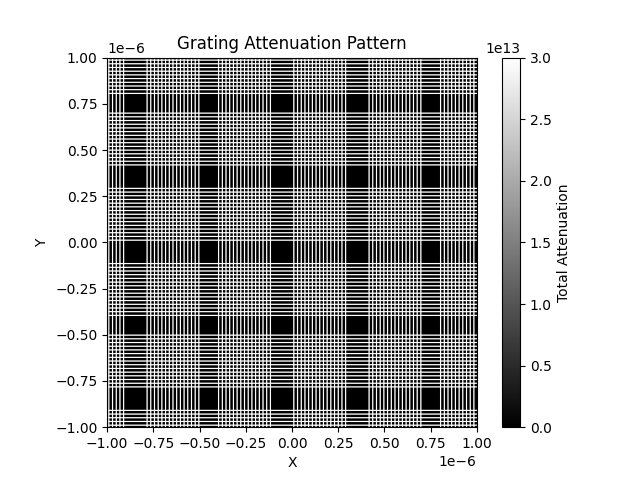

In [347]:
# Plot the Sample
import matplotlib.pyplot as plt

# Sum the attenuation over the z-axis to get a 2D image
attenuation_2d = np.sum(attenuation, axis=2)

# Plot the 2D image
plt.figure()
plt.imshow(attenuation_2d, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Grating Attenuation Pattern')
plt.colorbar(label='Total Attenuation')
plt.show()

In [ ]:
components = (
    comp.GaussBeam(
        z=0.0,
        voltage=200e3,
        # semi_angle=0.001,
        radius=10 * scale,
        wo=1e-10,
        amplitude=1.0,
    ),
    # comp.Lens(
    #     z=condenser_dist,
    #     z1=-condenser_dist,
    #     z2=sample_dist - condenser_dist,
    #     name='Condenser Lens',
    # ),
    comp.AttenuatingSample(
        z=sample_dist,
        points=points,
        rotation=0,
        attenuation=attenuation,
        centre_yx=[0, 0],
    ),
    # comp.Lens(
    #     z=objective_dist,
    #     z1=sample_dist - objective_dist,
    #     z2=total_dist - objective_dist,
    #     name='Objective Lens',
    # ),
    # comp.ProjectorLensSystem(
    #     first=comp.Lens(z=projector_dist, name='PL1', z1=-1, z2=1),
    #     second=comp.Lens(z=projector_dist + 1e-3, name='PL2', z1=-1, z2=1),
    #     name='Projector Lens System',
    # ),
    comp.AccumulatingDetector(
        z=total_dist,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=1,
        interference='ray'
    )
)



model = Model(components, backend='gpu')

sample_detector_model = comp.Detector(z=1.0,
                                      pixel_size=1e-7, 
                                      shape=(128, 128),
                                      interference='ray')

print(n_rays)
rays_before_sample = model.run_to_z(z=sample_dist, num_rays=n_rays)
rays_after_sample = model.run_to_z(z=sample_dist+sample_thickness*2, num_rays=n_rays)

print(np.average(rays_before_sample.amplitude))
print(np.average(rays_after_sample.amplitude))
print(np.min(rays_before_sample.amplitude))
print(np.min(rays_after_sample.amplitude))
all_rays = tuple(model.run_iter(num_rays=1e6, random=False))
rays_at_start = all_rays[0]
rays_at_end = all_rays[-1]

image_before_sample = sample_detector_model.get_image(rays_before_sample)
image_after_sample = sample_detector_model.get_image(rays_after_sample)
image_at_end = model.detector.get_image(rays_at_end)


100000
1.0
0.9524918703306495
1.0
0.0


In [349]:
# fig, ax = plt.subplots(figsize=(10, 6))

# # Plot the attenuating sample as a filled rectangle
# sample_y = sample_centre_yx[0] + np.array([-0.05, 0.05, 0.05, -0.05, -0.05])
# sample_z = [sample_dist, sample_dist, sample_dist + 50e-9, sample_dist + 50e-9, sample_dist]
# ax.fill(sample_y, sample_z, 'gray', edgecolor='black')

# xvals = np.stack(tuple(r.x_central.get() for r in all_rays), axis=0)
# zvals = np.asarray(tuple(r.z for r in all_rays))

# widest_ray_xvals = xvals[:, [np.argmin(xvals), np.argmax(xvals)]]

# print(zvals)

# ax.plot(widest_ray_xvals, zvals, label='Widest Ray')

# ax.set_xlim(-1e-8, 1e-8)
# ax.set_ylim(0.5 - 1000e-9, 0.5 + 1000e-9)
# ax.set_xlabel('x (m)')
# ax.set_ylabel('z (m)')
# ax.set_title('Cross Section Plot')
# ax.legend()
# # Plot the convergence angle as an arc
# ax.invert_yaxis()

# plt.show()

-1e-06 1e-06 -1e-06 1e-06


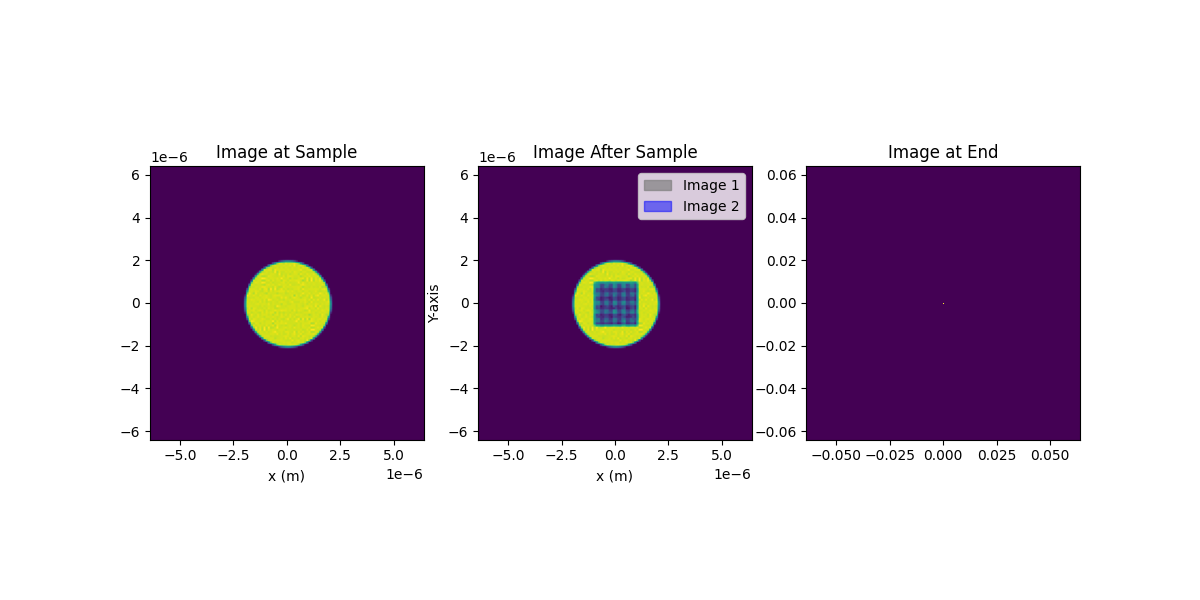

In [350]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].imshow(np.abs(image_before_sample), extent=sample_detector_model.extent)
# axs[0].plot(rays_before_sample.x_central, rays_before_sample.y_central, 'r.', markersize=1)
axs[0].set_xlabel('x (m)')
axs[0].set_title('Image at Sample')

extent1 = sample_detector_model.extent
extent2 = [x.min(), x.max(), y.min(), y.max()]

print(x.min(), x.max(), y.min(), y.max())   
axs[1].imshow(np.abs(image_after_sample), extent=extent1, alpha=1)
# axs[1].imshow(attenuation_2d, extent=extent2, origin='lower', cmap='gray', alpha=0.5)

# Optional: Adjust the axes limits to ensure both images are fully visible
all_extents = [
    extent1,
    extent2
]

# Calculate combined extent
left = min(extent[0] for extent in all_extents)
right = max(extent[1] for extent in all_extents)
bottom = min(extent[2] for extent in all_extents)
top = max(extent[3] for extent in all_extents)

axs[1].set_xlim(left, right)
axs[1].set_ylim(bottom, top)

# Add labels and title
axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Y-axis')
axs[1].set_title('Overlay of Two Images with Different Extents')

# Add a legend or colorbars if necessary
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Create custom legend
legend_elements = [
    mpatches.Patch(facecolor='gray', edgecolor='gray', alpha=0.7, label='Image 1'),
    mpatches.Patch(facecolor='blue', edgecolor='blue', alpha=0.5, label='Image 2')
]
axs[1].legend(handles=legend_elements, loc='upper right')

# axs[1].plot(rays_after_sample.x_central, rays_after_sample.y_central, 'r.', markersize=1)
axs[1].set_xlabel('x (m)')
axs[1].set_title('Image After Sample')

axs[2].imshow(np.abs(image_at_end), extent=model.detector.extent)
axs[2].set_title('Image at End')

plt.show()